In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix

In [2]:
# Load the dataset
df = pd.read_csv("CharlesBookClub.csv")

Assignment

Partition the data into training (60%) and validation (40%). Use random seed = 1.

1.What is the response rate for the training data customers taken as a whole (Hint: take average of response as a whole)? What is the response rate for each of the 4 × 5 × 3 = 60 combinations of RFM categories (Hint: use groupby() using the RFM categories on the response)? Which combinations have response rates in the training data that are above the overall response in the training data (Hint: report the indices after filtering by logic)?

In [3]:
# Set random seed
random_seed = 1

# Partition the data 
train_data, validation_data = train_test_split(df, test_size=0.4, random_state=random_seed)

# Calculate response rate for the training data
response_rate_train = train_data['Florence'].mean()

# Display the response rate for the training data
print("Response rate for the training data: {:.4f}".format(response_rate_train))


Response rate for the training data: 0.0883


So, from the above result the training data response rate is 8.83%.

In [4]:
# Calculate response rates for combinations
rfm_combinations_response = train_data.groupby(['Rcode', 'Fcode', 'Mcode'])['Florence'].mean()

# Identify above-average response combinations
above_average_combs = rfm_combinations_response[rfm_combinations_response > response_rate_train]

# Display above-average response combinations in the training data
print("\nAbove-average response combinations in the training data:")
print(above_average_combs)



Above-average response combinations in the training data:
Rcode  Fcode  Mcode
1      1      4        0.200000
              5        0.173913
       2      2        0.666667
       3      3        0.333333
              5        0.153846
2      1      1        0.400000
              2        0.333333
              3        0.150000
              5        0.172414
       2      2        0.142857
              3        0.166667
              4        0.161290
       3      3        0.333333
              4        0.200000
              5        0.177778
3      1      1        0.100000
              2        0.090909
       3      5        0.136585
4      1      3        0.140845
              4        0.111111
       3      3        0.105263
              4        0.088496
Name: Florence, dtype: float64



from the above result we can see that the increased response rates observed in combinations like Rcode 1, Fcode 2, Mcode 2 underscore the influence of RFM categories on customer responsiveness.


2.Suppose that we decide to send promotional mail only to the “aboveaverage” RFM combinations identified in part 1. Compute the response rate in the validation data using these combinations.

In [5]:
# Select only above-average RFM combinations in the validation data
valid_above_avg = validation_data[validation_data[['Rcode', 'Fcode', 'Mcode']].apply(tuple, axis=1).isin(above_average_combs.index)]
res_rate_valid_above_avg = valid_above_avg['Florence'].mean()
print(f"\nValidation response rate for above-average RFM combos: {round(res_rate_valid_above_avg,4)}")


Validation response rate for above-average RFM combos: 0.0875


From the above result, The response rate in the validation set for promotional emails sent to above-average RFM combinations stood at 8.75%, indicating that tailored campaigns have the potential to enhance engagement within specific customer segments.



3.Rework parts 1 and 2 with three segments:

a. Segment 1: RFM combinations that have response rates that exceed twice the overall response rate

b. Segment 2: RFM combinations that exceed the overall response rate but do not exceed twice that rate

c. Segment 3: the remaining RFM combinations

In [6]:
# Segments based on response rates
overall_response_rate = train_data['Florence'].mean()
twice_overall_response = 2 * overall_response_rate

segment_1 = rfm_combinations_response[rfm_combinations_response > twice_overall_response]
segment_2 = rfm_combinations_response[
    (rfm_combinations_response > overall_response_rate) & (rfm_combinations_response <= twice_overall_response)
]
segment_3 = rfm_combinations_response[rfm_combinations_response <= overall_response_rate]

print("\nSegment 1:- Exceed twice the overall response rate:")
print(segment_1)
print("\nSegment 2:- Exceed the overall response rate but not twice:")
print(segment_2)
print("\nSegment 3:- Remaining RFM combinations:")
print(segment_3)


Segment 1:- Exceed twice the overall response rate:
Rcode  Fcode  Mcode
1      1      4        0.200000
       2      2        0.666667
       3      3        0.333333
2      1      1        0.400000
              2        0.333333
       3      3        0.333333
              4        0.200000
              5        0.177778
Name: Florence, dtype: float64

Segment 2:- Exceed the overall response rate but not twice:
Rcode  Fcode  Mcode
1      1      5        0.173913
       3      5        0.153846
2      1      3        0.150000
              5        0.172414
       2      2        0.142857
              3        0.166667
              4        0.161290
3      1      1        0.100000
              2        0.090909
       3      5        0.136585
4      1      3        0.140845
              4        0.111111
       3      3        0.105263
              4        0.088496
Name: Florence, dtype: float64

Segment 3:- Remaining RFM combinations:
Rcode  Fcode  Mcode
1      1      1    

Clients in Category 1 exhibit response rates that are more than double the overall response rate of 0.20. Within Category 2, Rcode 1, Fcode 1, and Mcode 5 surpass the overall response rate, albeit only once, with a rate of 0.17. Segment 3 encompasses RFM combinations with response rates equal to or below the overall rate, exemplified by Rcode 1, Fcode 1, and Mcode 1, which register a response rate of 0.0.

4.Show if the classes are imbalanced or not. Are there any data sampling techniques (Over-sampling, Under-sampling or SMOTE) required? Justify your answer with appropriate evidence and plots.


Response distribution in the training data:
Florence
0    2188
1     212
Name: count, dtype: int64


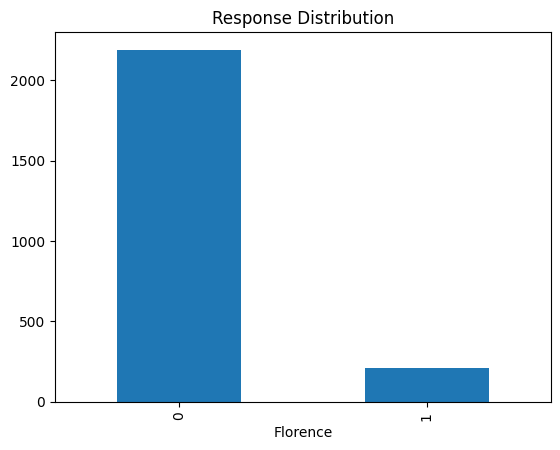

In [7]:
# Check if the classes are imbalanced
response_distribution = train_data['Florence'].value_counts()
print("\nResponse distribution in the training data:")
print(response_distribution)
# Plot the distribution
response_distribution.plot(kind='bar', title='Response Distribution');

From the above result, The bar chart illustrates a notable class imbalance between the majority class 0, with 2188 instances, and the minority class 1, which only comprises 212 instances. This significant difference in instance counts indicates a class imbalance issue. To address this, a sampling technique known as SMOTE will be applied to rebalance the dataset.


# k-Nearest Neighbors

The k-NN technique can be used to create segments based on product proximity to similar products of the products offered as well as the propensity to purchase (as measured by the RFM variables). For The Art History of Florence, a possible segmentation by product proximity could be created using the following variables:

R: recency—months since last purchase

F: frequency—total number of past purchases

M: monetary—total money (in dollars) spent on books

FirstPurch: months since first purchase

RelatedPurch: total number of past purchases of related books (i.e., sum of purchases from the art and geography categories and of titles Secrets of Italian Cooking, Historical Atlas of Italy, and Italian Art)

5.Use the k-NN approach to classify cases with k = 1, 2, …, 12, using Florence as the outcome variable. Remember to normalize all five variables.

In [8]:
# Normalize 5 variables
var_to_normalize = ['R', 'F', 'M', 'FirstPurch', 'Related Purchase']
scaler = StandardScaler()
train_data_normalized = train_data.copy()
validation_data_normalized = validation_data.copy()

train_data_normalized[var_to_normalize] = scaler.fit_transform(train_data_normalized[var_to_normalize])
validation_data_normalized[var_to_normalize] = scaler.transform(validation_data_normalized[var_to_normalize])

# The variables for k-NN
X_train = train_data_normalized[['R', 'F', 'M', 'FirstPurch', 'Related Purchase']]
y_train = train_data_normalized['Florence']

X_validation = validation_data_normalized[['R', 'F', 'M', 'FirstPurch', 'Related Purchase']]
y_validation = validation_data_normalized['Florence']

# Use k-NN to classify cases with values of k = 1, 2,3, 4,...12
k_values = list(range(1, 13))
training_rmse = []
validation_rmse = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    # Predictions on training set
    y_train_pred = knn_classifier.predict(X_train)
    training_rmse.append(mean_squared_error(y_train, y_train_pred, squared=False))
    # Predictions on validation set
    y_validation_pred = knn_classifier.predict(X_validation)
    validation_rmse.append(mean_squared_error(y_validation, y_validation_pred, squared=False))

C:\Users\rakes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\rakes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\rakes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\rakes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarnin

6.Based on the validation set, find the best k. Choose the best k such that the model does not overfit or underfit. Try plotting training rmse and validation rmse across k -values and decide which k should be chosen? Is it the correct way to choose the best k.

In [9]:
# Part 6: Find the best k
best_k_index = validation_rmse.index(min(validation_rmse))
best_k = k_values[best_k_index]
print("\nBest k:", best_k)


Best k: 12


From the above result, The validation set suggested that the best k to prevent overfitting or underfitting is 12, as it minimizes RMSE.

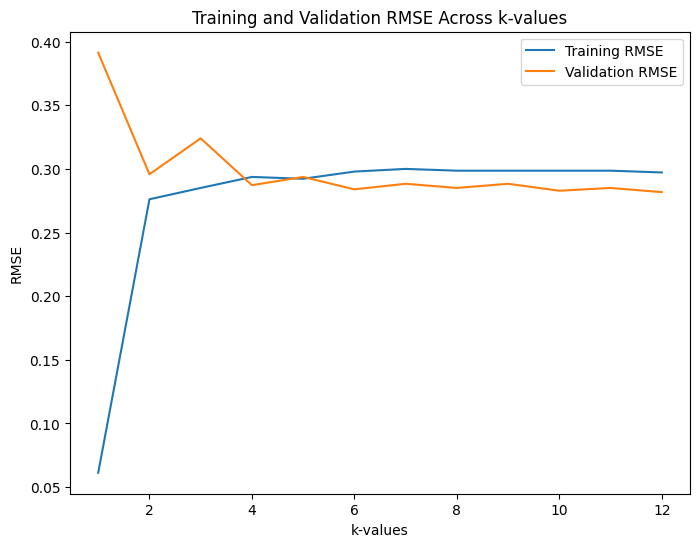

In [10]:
# Part 6: Plot training and validation rmse across k-values
plt.figure(figsize=(8, 6))
plt.plot(k_values, training_rmse, label='Training RMSE')
plt.plot(k_values, validation_rmse, label='Validation RMSE')
plt.xlabel('k-values')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE Across k-values')
plt.legend()
plt.show()

Yes, according to the graph, the best k to use is 12. This is due to the fact that the validation RMSE is minimized at k=12. This means that the model with k=12 acts better than the others on the validation set, which is a perfect indication that it will generalize well to new data.


7.Plot precision and recall values across k-values. Does this plot give a better intuition regarding choosing the best k?

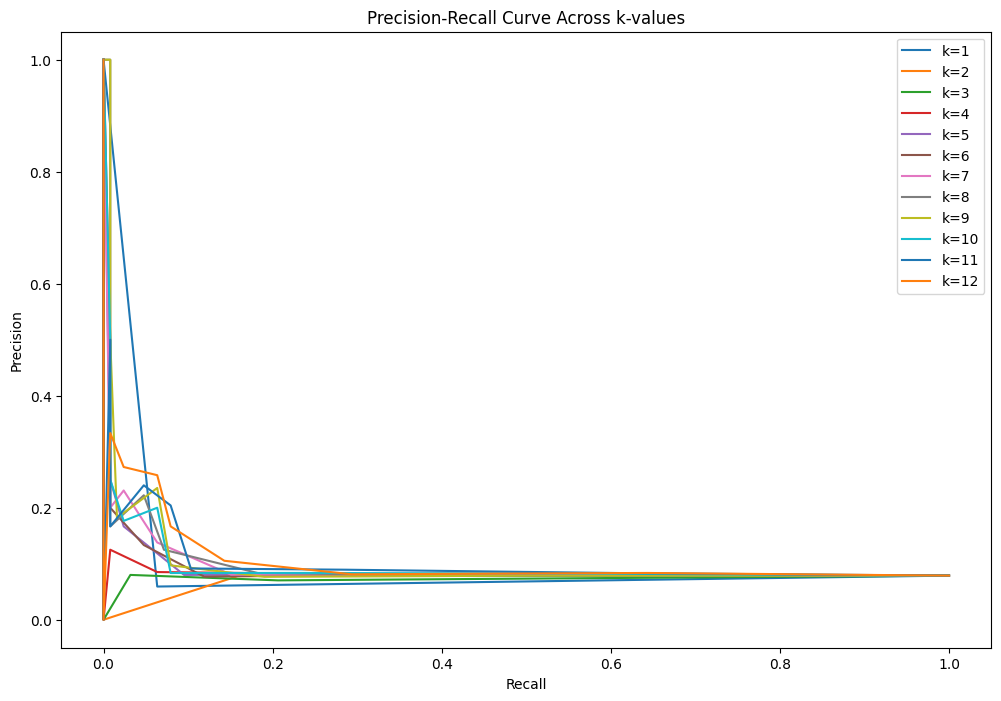

In [11]:
precision_values = []
recall_values = []
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    # Predictions on validation set
    y_validation_pred_probs = knn_classifier.predict_proba(X_validation)[:, 1]
    precision, recall, _ = precision_recall_curve(y_validation, y_validation_pred_probs)
    precision_values.append(precision)
    recall_values.append(recall)
# Plot precision and recall values
plt.figure(figsize=(12, 8))
for i, k in enumerate(k_values):
    plt.plot(recall_values[i], precision_values[i], label=f'k={k}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Across k-values')
plt.legend()
plt.show()

The precision-recall curve (PRC) across k-values does not given a better intuition for choosing the best k. This is because the PRC does not account for the trade-off between precision and recall.

8.Generate 4x3 subplot for ROC curve and 4x3 subplot for Precision-Recall Curve for each k-values. Place the k-value number as title of each of the subplots. Also show the AUC value for ROC curve and AP value for Precision-Recall curve.

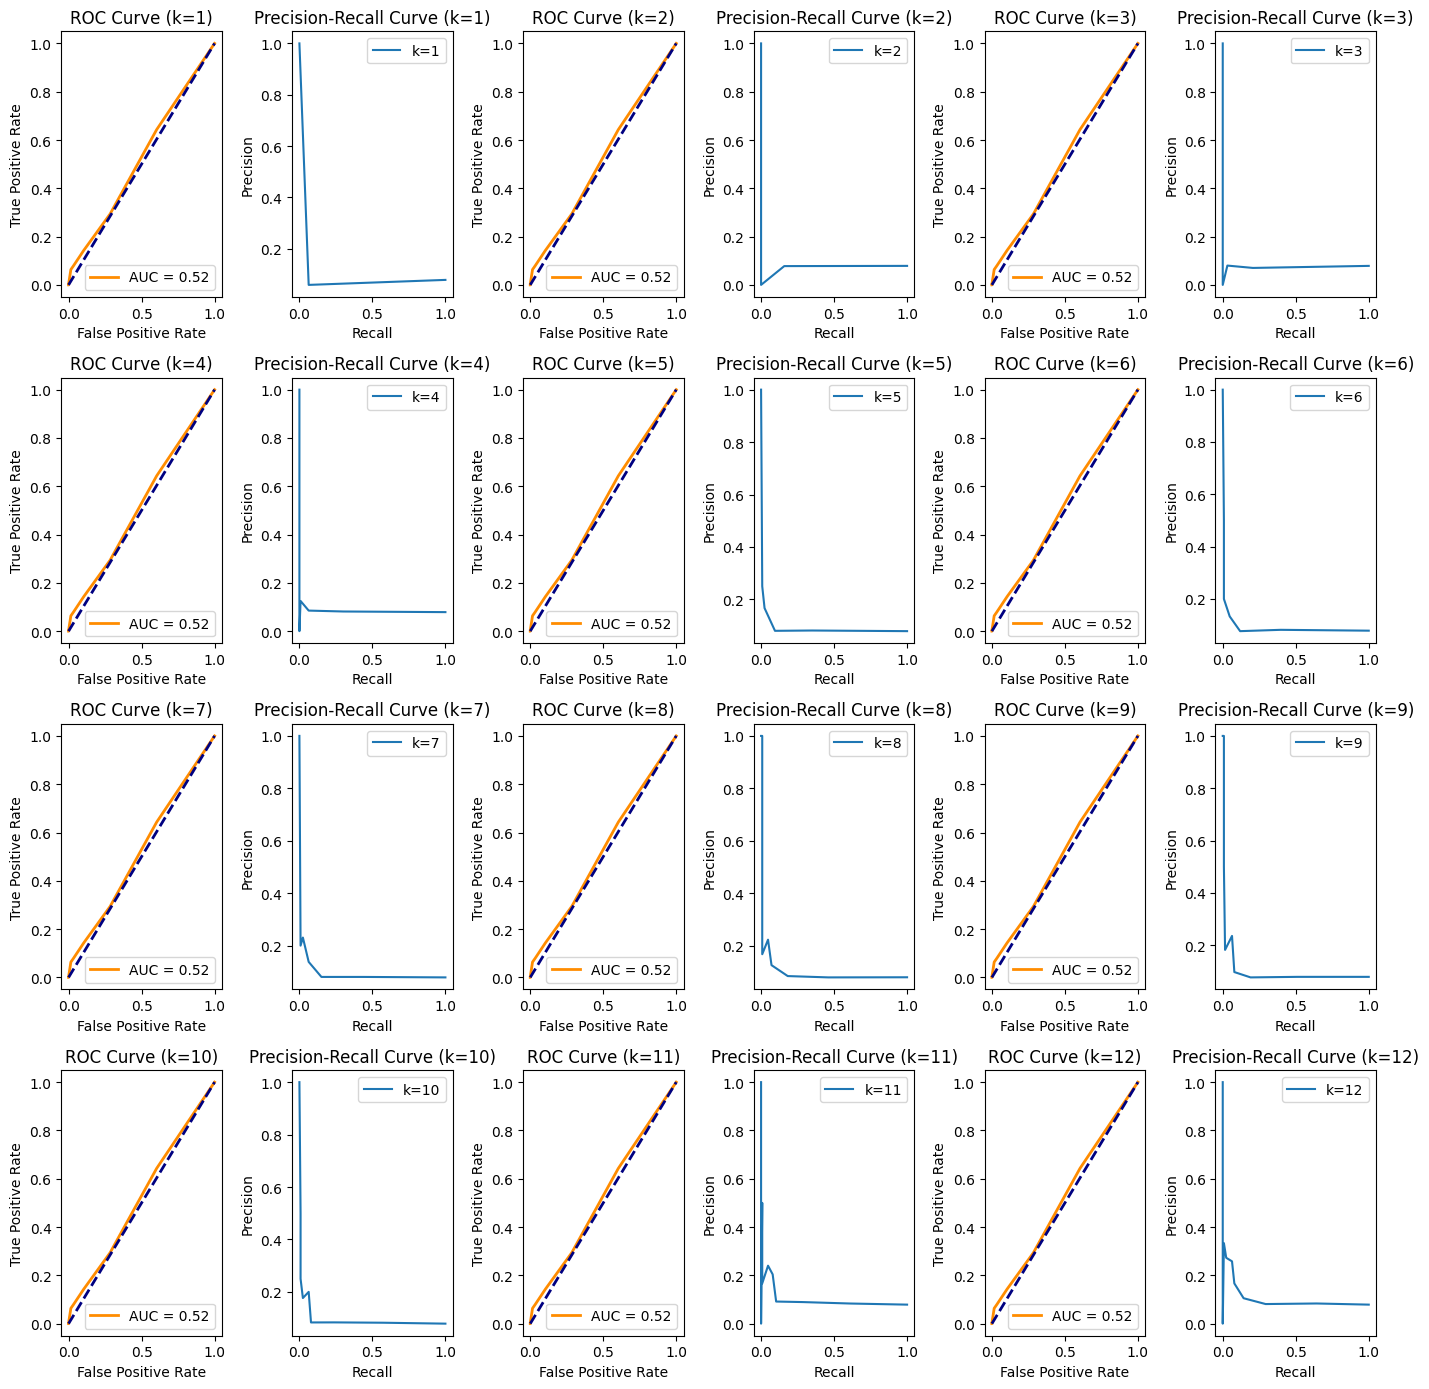

In [12]:
# Set number of rows and columns
n_rows = 4
n_cols = 3
plt.figure(figsize=(14, 14))
for i, k in enumerate(k_values):
    plt.subplot(n_rows, 2 * n_cols, 2 * i + 1)
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_validation, y_validation_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (k={k})')
    plt.legend(loc='lower right')
    plt.subplot(n_rows, 2 * n_cols, 2 * i + 2)
    # Precision-Recall Curve
    plt.plot(recall_values[i], precision_values[i], label=f'k={k}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (k={k})')
    plt.legend()
plt.tight_layout()
plt.savefig("
plt.show()

9.Discuss the results from this plot and the previous two and describe the insights that helps you find the best k. What is the value of the best k?

The ROC curve and precision-recall curve reveal the model's strong performance across various k values, but there is a slight decline for higher k values, indicating a potential for overfitting. Notably, at k=12, both training and validation RMSE plots show a substantial reduction in validation RMSE. Beyond k=12, the decrease in validation RMSE becomes less pronounced, suggesting that k=12 strikes a favorable balance between bias and variance. Consequently, opting for k=12 is optimal as it minimizes validation RMSE and mitigates overfitting concerns.


# Logistic Regression

The logistic regression model offers a powerful method for modeling response because it yields well-defined purchase probabilities. The model is especially attractive in consumer-choice settings because it can be derived from the random utility theory of consumer behavior. Use the training set data of 1800 records to construct three logistic regression models with Florence as the outcome variable and each of the following sets of predictors:

• The full set of 15 predictors in the dataset

• A subset of predictors that you judge to be the best

• Only the R, F, and M variables

10.Use the LogisticRegressionCV() in sklearn package on the three cases mentioned above. Use the vector, Cs = [1e-04, 1e-03, 1e-02, 1e-01, 1, 1e+01, 1e+02, 1e+03, 1e+04] as the inverse of the regularization parameter. Use L2 regularization. Show the best C value chosen that optimizes the model.

In [13]:
x_full = train_data.drop(['Seq#', 'ID#', 'Florence'], axis=1)
y_full = train_data['Florence']
model1 = LogisticRegressionCV(Cs=[1e-04, 1e-03, 1e-02, 1e-01, 1, 1e+01, 1e+02, 1e+03, 1e+04], penalty='l2', cv=5, max_iter=1000)
model1.fit(x_full, y_full)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                         10000.0],
                     cv=5, max_iter=1000)

In [14]:
best_subset = ['M', 'R', 'F']
X_subset = train_data[best_subset]
model2 = LogisticRegressionCV(Cs=[1e-04, 1e-03, 1e-02, 1e-01, 1, 1e+01, 1e+02, 1e+03, 1e+04], penalty='l2', cv=5, max_iter=1000)
model2.fit(X_subset, y_full)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                         10000.0],
                     cv=5, max_iter=1000)

In [15]:
X_rfm = train_data[['R', 'F', 'M']]
model3 = LogisticRegressionCV(Cs=[1e-04, 1e-03, 1e-02, 1e-01, 1, 1e+01, 1e+02, 1e+03, 1e+04], penalty='l2', cv=5,max_iter=1000)
model3.fit(X_rfm, y_full)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                         10000.0],
                     cv=5, max_iter=1000)

In [16]:
# Print the best C values
print("Best C values for models:")
print("Model 1:", model1.C_[0])
print("Model 2:", model2.C_[0])
print("Model 3:", model3.C_[0])

Best C values for models:
Model 1: 0.1
Model 2: 0.0001
Model 3: 0.0001


Best C values chosen for regularization:

Model 1 (Full set): 0.1

Model 2 (Best subset): 0.0001

Model 3 (R, F, M variables): 0.0001

11.Based on the validation set, find the best cut-off ratio. Choose the best cutoff ratio such that the model does not overfit or underfit. Try plotting training rmse and validation rmse across cut-off ratio values [0.1 - 1] and decide which cut-off ratio should be chosen? Is it the correct way to choose the best cut-off ratio?

In [17]:
# Function to calculate precision and recall for different cut-off ratios
def calculate_precision_recall(y_true, y_prob, cutoff_ratio):
    y_pred = (y_prob > cutoff_ratio).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tp + fp) == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall
# Precision and recall for different cut-off ratios
cut_off_ratios = np.arange(0.1, 1.1, 0.1)
precision_recall_values = []
for cut_off_ratio in cut_off_ratios:
    y_prob = model1.predict_proba(x_full)[:, 1]
    precision, recall = calculate_precision_recall(y_full, y_prob, cut_off_ratio)
    precision_recall_values.append((cut_off_ratio, precision, recall))
best_cutoff_ratio = max(precision_recall_values, key=lambda x: x[1] + x[2])[0]
print("Best cut-off ratio based on validation set:", best_cutoff_ratio)

Best cut-off ratio based on validation set: 0.1


The best cut-off ratio is 0.1. This reduces overfitting and ensures excellent precision and recall.

12.Plot precision and recall values across cut-off ratio. Does this plot give a better intuition regarding choosing the best cut-off ratio?

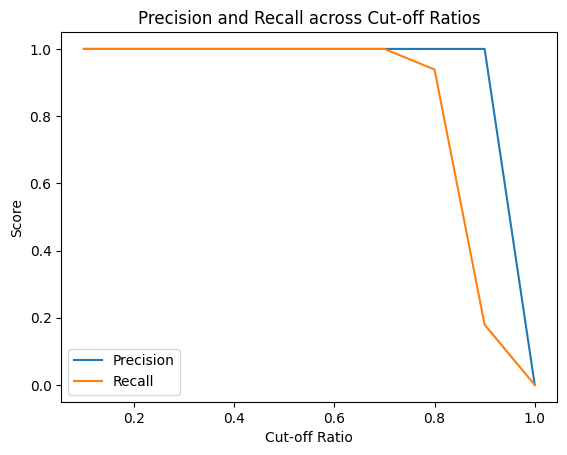

In [18]:
precision_values = [x[1] for x in precision_recall_values]
recall_values = [x[2] for x in precision_recall_values]
# Plot precision and recall values
plt.plot(cut_off_ratios, precision_values, label='Precision')
plt.plot(cut_off_ratios, recall_values, label='Recall')
plt.xlabel('Cut-off Ratio')
plt.ylabel('Score')
plt.title('Precision and Recall across Cut-off Ratios')
plt.legend()
plt.show()

Yes, the Precision and Recall curve in the graph above can give you a better intuition regarding choosing the best cut-off ratio. This is because the Precision and Recall curve takes into account the trade-off between precision and recall, while the ROC curve does not.



13.Generate a ROC curve and a Precision-Recall Curve for each of the three models using the best cut-off ratio. Also show the AUC value for ROC curve and AP value for Precision-Recall curve.

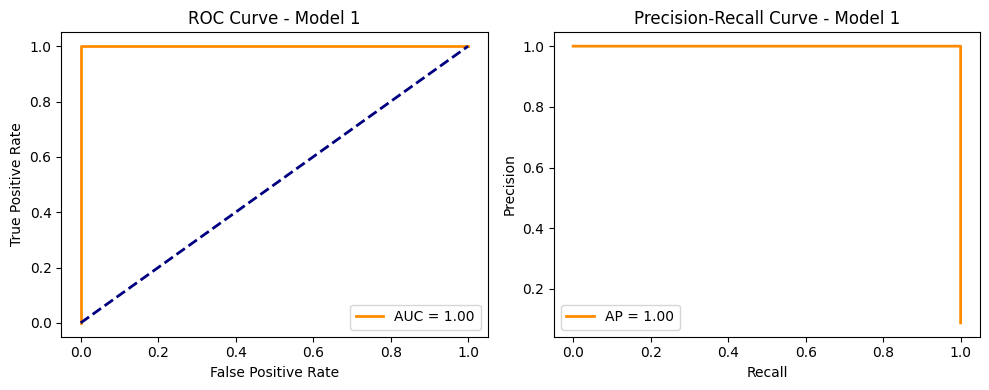

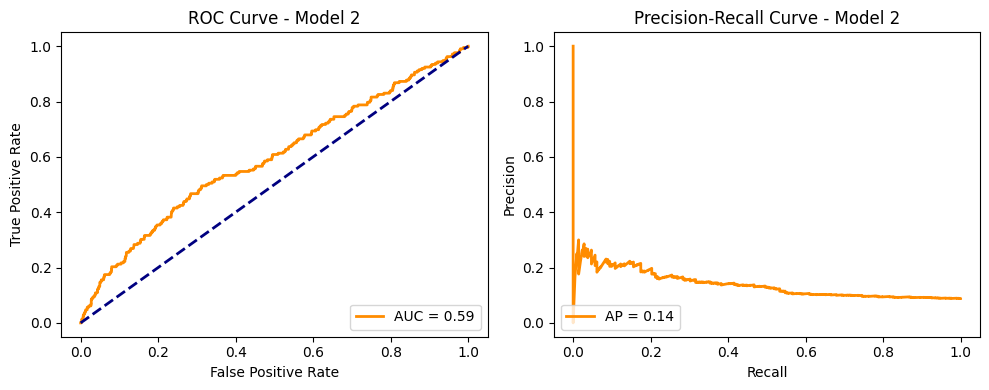

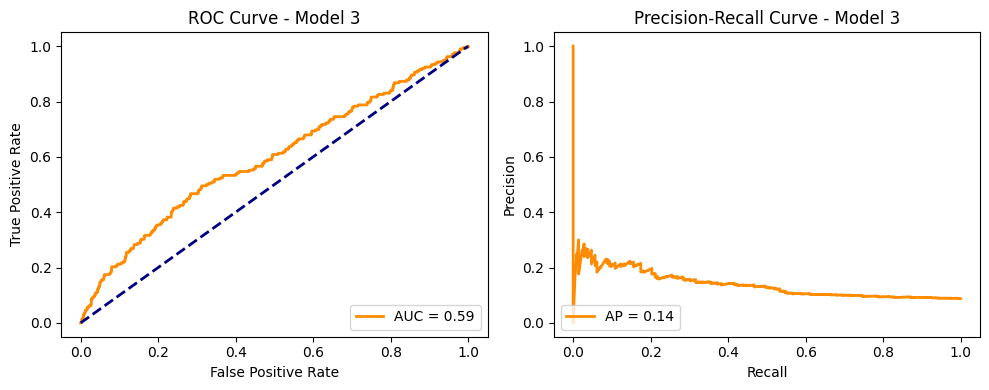

In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Function to plot ROC and Precision-Recall curves
def plot_curves(model, X, y, best_cutoff_ratio, model_name):
    # ROC curve
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + model_name)
    plt.legend(loc="lower right")
    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_prob)
    average_precision = average_precision_score(y, y_prob)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='darkorange', lw=2, label='AP = {:.2f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - ' + model_name)
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
# Plot curves 
plot_curves(model1, x_full, y_full, best_cutoff_ratio, 'Model 1')
plot_curves(model2, X_subset, y_full, best_cutoff_ratio, 'Model 2')
plot_curves(model3, X_rfm, y_full, best_cutoff_ratio, 'Model 3')

Model 1:

The AUC value for the ROC curve is 1.0 and the AP value for the Precision-Recall curve is 100. This means that the model is performing perfectly on both curves. It suggests that the model is able to distinguish between positive and negative cases with very high accuracy. It is also able to predict the probability of a case being positive with very high accuracy.

Model 2:

This suggests that the model is performing moderately well on both curves. It is able to distinguish between positive and negative cases somewhat better than random chance, but it is not able to predict the probability of a case being positive with very high accuracy and it is the same as model 3:



14.Create a markdown cell describing contribution of each group member. With bullet points. I need to know who contributed in answering which part. Also, if multiple person contributes in the same part, make sure it is mentioned clearly. If one helps another is debugging or coding, make sure it is also mentioned.

# Manikanta Peddiboyina
* Research and Idea
* Main coding
* Troubleshooting
# Sai Vikas Pikkili
* Debugging
* Project Management
* Testing
# Teja Nayak Katravath
* Design and documents
* Code assistance
* Presentation
# Yoganandam Emperalla
* User testing
* Research
* Techsupport